In [2]:
%load_ext autoreload
%autoreload 2
import uproot
import numpy as np
import matplotlib.pyplot as plt
import awkward as ak
import sys
import coffea.util as util

sys.path.append("../../analysisTools/")
from analysisTools import Analyzer
from analysisTools import loadSchema

from coffea.nanoevents import NanoEventsFactory, NanoAODSchema, BaseSchema
from mySchema import MySchema

import numba as nb

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# sanity check

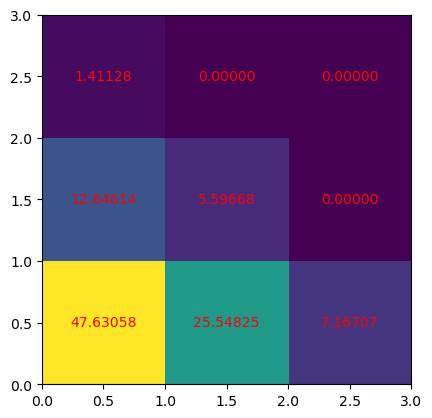

In [3]:
n_eMatch = ak.count_nonzero(t.Electron.genMatched,axis=1)
n_leMatch = ak.count_nonzero(t.LptElectron.genMatched,axis=1)

hist, xedges, yedges = np.histogram2d(n_eMatch,n_leMatch,bins=np.arange(4))
plt.imshow(hist.T, origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap='viridis')
for i in range(len(xedges) - 1):
    for j in range(len(yedges) - 1):
        plt.text((xedges[i] + xedges[i+1]) / 2, (yedges[j] + yedges[j+1]) / 2, 
                 f"{100*hist[i, j]/np.sum(hist):.5f}", ha='center', va='center', color='red')

# check out overlap

In [4]:
n_gen_eles = len(t.GenEle) + len(t.GenPos)
print(n_gen_eles)

39312


In [6]:
n_genMatch_ele = ak.count_nonzero(t.Electron.genMatched)
n_genMatch_ele_pt5 = ak.count_nonzero(t.Electron.genMatched & (t.Electron.pt < 5))
n_genMatch_ele_pt5_lowMatch = ak.count_nonzero(t.Electron.genMatched & (t.Electron.pt < 5) & (t.Electron.hasLptMatch))

print("Number of GED gen matches: ",n_genMatch_ele)
print("Number of GED gen matches with pT < 5: ",n_genMatch_ele_pt5)
print("Number of GED gen matches with pT < 5 but matched to lpt: ",n_genMatch_ele_pt5_lowMatch)

Number of GED gen matches:  1324
Number of GED gen matches with pT < 5:  754
Number of GED gen matches with pT < 5 but matched to lpt:  552


In [7]:
n_genMatch_ele = ak.count_nonzero(t.LptElectron.genMatched)
n_genMatch_ele_pt5 = ak.count_nonzero(t.LptElectron.genMatched & (t.LptElectron.pt < 5))
n_genMatch_ele_pt5 = 
n_genMatch_ele_pt5_lowMatch = ak.count_nonzero(t.LptElectron.genMatched & (t.LptElectron.pt < 5) & (t.LptElectron.xCleaned))

print("Number of LPT gen matches: ",n_genMatch_ele)
print("Number of LPT gen matches with pT < 5: ",n_genMatch_ele_pt5)
print("Number of GED gen matches with pT < 5 but cross-cleaned: ",n_genMatch_ele_pt5_lowMatch)

Number of LPT gen matches:  659
Number of LPT gen matches with pT < 5:  481
Number of GED gen matches with pT < 5 but cross-cleaned:  0


In [8]:
genE_matchL = (t.GenEle.matched) & (t.GenEle.matchType == 'L')
genE_matchR = (t.GenEle.matched) & (t.GenEle.matchType == 'R')
genE_matchedL = t.GenEle[genE_matchL]
genE_matchedR = t.GenEle[genE_matchR]
recoE_matchedL = t.LptElectron[genE_matchL][ak.from_iter(genE_matchedL.matchIdxLocal[:,np.newaxis])][:,0]
recoE_matchedR = t.Electron[genE_matchR][ak.from_iter(genE_matchedR.matchIdxLocal[:,np.newaxis])][:,0]

genP_matchL = (t.GenPos.matched) & (t.GenPos.matchType == 'L')
genP_matchR = (t.GenPos.matched) & (t.GenPos.matchType == 'R')
genP_matchedL = t.GenPos[genP_matchL]
genP_matchedR = t.GenPos[genP_matchR]
recoP_matchedL = t.LptElectron[genP_matchL][ak.from_iter(genP_matchedL.matchIdxLocal[:,np.newaxis])][:,0]
recoP_matchedR = t.Electron[genP_matchR][ak.from_iter(genP_matchedR.matchIdxLocal[:,np.newaxis])][:,0]

In [9]:
gen_matchedL = ak.concatenate([genE_matchedL,genP_matchedL],axis=0)
reco_matchedL = ak.concatenate([recoE_matchedL,recoP_matchedL],axis=0)

gen_matchedR = ak.concatenate([genE_matchedR,genP_matchedR],axis=0)
reco_matchedR = ak.concatenate([recoE_matchedR,recoP_matchedR],axis=0)

genAll = ak.concatenate([t.GenEle,t.GenPos],axis=0)

<BarContainer object of 9 artists>

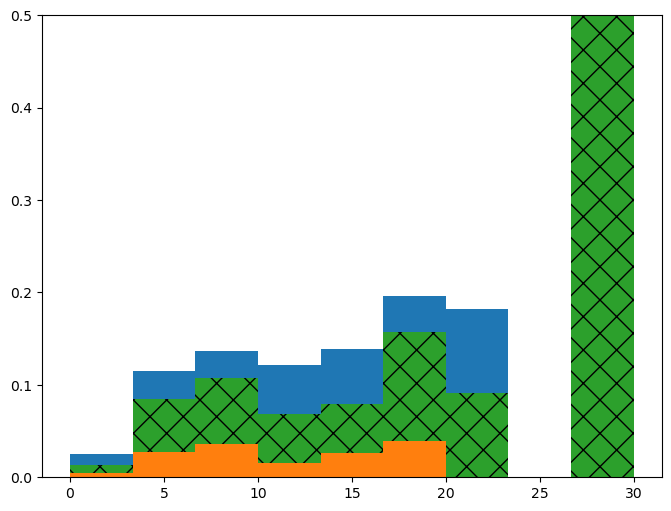

In [12]:
# match fractions by pT
bins = np.linspace(0,30,10)
w = bins[1]-bins[0]
centers = (bins[1:]+bins[:-1])/2

cts_genAll, _ = np.histogram(genAll.pt,bins=bins)
cts_Rmatch, _ = np.histogram(gen_matchedR[~reco_matchedR.hasLptMatch].pt,bins=bins)
cts_bothMatch, _ = np.histogram(gen_matchedR[reco_matchedR.hasLptMatch].pt,bins=bins)
cts_LMatch, _ = np.histogram(gen_matchedL.pt,bins=bins)

f_Rmatch = cts_Rmatch/cts_genAll
f_bothMatch = cts_bothMatch/cts_genAll
f_LMatch = cts_LMatch/cts_genAll

plt.figure(figsize=(8,6))
plt.bar(centers,f_Rmatch,width=w,color='C1')
plt.bar(centers,f_bothMatch,width=w,bottom=f_Rmatch,hatch='X',color='C2')
plt.bar(centers,f_LMatch,width=w,bottom=f_Rmatch+f_bothMatch,color='C0')

<BarContainer object of 9 artists>

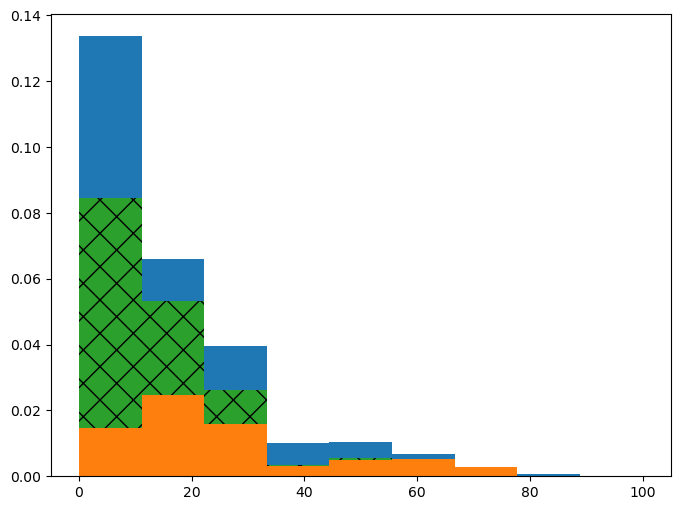

In [15]:
# match fractions by pT
bins = np.linspace(0,100,10)
w = bins[1]-bins[0]
centers = (bins[1:]+bins[:-1])/2

cts_genAll, _ = np.histogram(genAll.vxy,bins=bins)
cts_Rmatch, _ = np.histogram(gen_matchedR[~reco_matchedR.hasLptMatch].vxy,bins=bins)
cts_bothMatch, _ = np.histogram(gen_matchedR[reco_matchedR.hasLptMatch].vxy,bins=bins)
cts_LMatch, _ = np.histogram(gen_matchedL.vxy,bins=bins)

f_Rmatch = cts_Rmatch/cts_genAll
f_bothMatch = cts_bothMatch/cts_genAll
f_LMatch = cts_LMatch/cts_genAll

plt.figure(figsize=(8,6))
plt.bar(centers,f_Rmatch,width=w,color='C1')
plt.bar(centers,f_bothMatch,width=w,bottom=f_Rmatch,hatch='X',color='C2')
plt.bar(centers,f_LMatch,width=w,bottom=f_Rmatch+f_bothMatch,color='C0')

In [86]:
t.Electron.fields

['pt',
 'eta',
 'etaErr',
 'phi',
 'phiErr',
 'IDcutVeto',
 'IDcutLoose',
 'IDcutMed',
 'IDcutTight',
 'IDmvaIso90',
 'IDmvaIso80',
 'IDmvaIsoLoose',
 'IDmva90',
 'IDmva80',
 'IDmvaLoose',
 'angRes',
 'e',
 'vxy',
 'vz',
 'dxy',
 'dxyErr',
 'dz',
 'dzErr',
 'trkChi2',
 'trkIso',
 'trkRelIso',
 'calIso',
 'calRelIso',
 'PFIso',
 'PFRelIso',
 'miniIso',
 'miniRelIso',
 'chadIso',
 'nhadIso',
 'phoIso',
 'rhoEA',
 'trkProb',
 'numTrackerHits',
 'numPixHits',
 'numStripHits',
 'charge',
 'isPF',
 'genMatched',
 'matchType',
 'dRJets',
 'dPhiJets',
 'full55sigmaIetaIeta',
 'absdEtaSeed',
 'absdPhiIn',
 'HoverE',
 'abs1overEm1overP',
 'expMissingInnerHits',
 'conversionVeto',
 'hasLptMatch',
 'lptMatchIdx']

In [30]:
class test:
    def __init__(self):
        self.a = "attr A"
        self.b = "attr B"
    def show(self,attr):
        print(getattr(self,attr))

In [32]:
def changeA(obj):
    obj.a += "change "
    return obj.a
o = test()
print(o.a)
k=changeA(o)
print(k)
print(o.a)

attr A
attr Achange 
attr Achange 


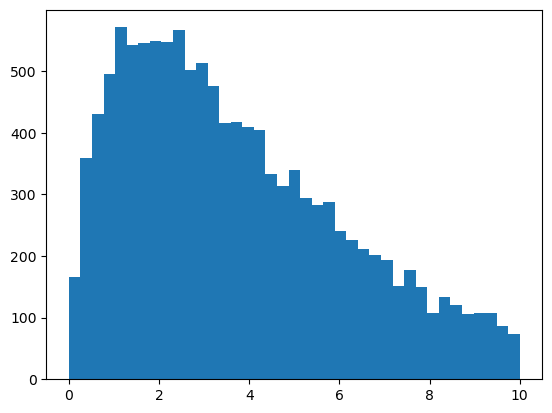

In [47]:
h=plt.hist(np.sqrt(t.GenEle.vxy**2 + t.GenEle.vz**2),bins=np.linspace(0,10,40))
#plt.yscale('log')

In [70]:
def exp(x,A,B):
    return A*np.exp(-x/B)
from scipy.optimize import curve_fit

r3 = np.sqrt((t.GenEle.vx - t.PV.x)**2 + (t.GenEle.vy - t.PV.y)**2 + (t.GenEle.vz - t.PV.z)**2)
h,bins=np.histogram(r3,bins=np.linspace(0,10,60),density=True)
popt,pcov = curve_fit(exp,bins[:-1],h)

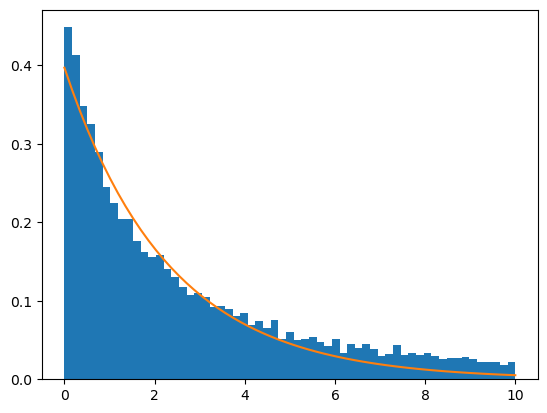

In [71]:
hplt=plt.hist(r3,bins=bins,density=True)
plt.plot(bins,exp(bins,*popt))

In [72]:
popt

array([0.39683724, 2.30554932])